In [ ]:
# 1. Load the SH17 Dataset
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!kaggle datasets download -d mugheesahmad/sh17-dataset-for-ppe-detection
!unzip sh17-dataset-for-ppe-detection.zip -d SH17_dataset

# 2. Data Cleaning and Preprocessing
import os
import pandas as pd
import cv2
import numpy as np
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define dataset paths
dataset_path = 'SH17_dataset'
image_dir = os.path.join(dataset_path, 'images')
label_dir = os.path.join(dataset_path, 'labels')

# Read image file paths and corresponding labels
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpeg')]
label_paths = [os.path.join(label_dir, label) for label in os.listdir(label_dir) if label.endswith('.txt')]

# Pair images with their labels
data = []
for image_path in image_paths:
    label_path = image_path.replace('images', 'labels').replace('.jpeg', '.txt')
    if os.path.exists(label_path):
        data.append({'image_path': image_path, 'label_path': label_path})
    else:
        logging.warning(f"Label file not found for image: {image_path}")

df = pd.DataFrame(data)

# Image preprocessing function
def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            logging.error(f"Failed to read image: {image_path}")
            return np.zeros((224 * 224 * 3,)).tolist()
        image = cv2.resize(image, (224, 224))
        image = image / 255.0  # Normalize pixel values
        return image.flatten().tolist()
    except Exception as e:
        logging.error(f"Error in preprocessing image {image_path}: {e}")
        return np.zeros((224 * 224 * 3,)).tolist()

# Apply preprocessing to images
df['preprocessed_image'] = df['image_path'].apply(preprocess_image)

# Define PPE classes
PPE_CLASSES = ['hardhat', 'vest', 'gloves', 'mask', 'goggles', 'face shield',
               'ear protection', 'knee pads', 'elbow pads', 'safety shoes',
               'safety harness', 'protective clothing', 'fire-resistant clothing',
               'hearing protection', 'respirators', 'chemical gloves',
               'high-visibility clothing']

# YOLO to one-hot encoding function
def yolo_to_onehot(label_path):
    onehot = [0] * len(PPE_CLASSES)
    try:
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id = int(line.split()[0])
                if class_id < len(PPE_CLASSES):
                    onehot[class_id] = 1
                else:
                    logging.error(f"Invalid class_id {class_id} in label file: {label_path}")
    except Exception as e:
        logging.error(f"Error reading label file {label_path}: {e}")
    return onehot

# Apply one-hot encoding to labels
df['onehot_encoding'] = df['label_path'].apply(yolo_to_onehot)

# Show preprocessed DataFrame
print(df.head())

# 4. Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Count frequency of each PPE class
class_frequencies = np.sum(np.array(df['onehot_encoding'].tolist()), axis=0)
plt.figure(figsize=(10, 6))
sns.barplot(x=PPE_CLASSES, y=class_frequencies)
plt.xticks(rotation=90)
plt.title('Frequency of Each PPE Class')
plt.show()

# Count number of PPE per image
class_counts = df['onehot_encoding'].apply(lambda x: sum(x))  # Count number of PPE per image
sns.histplot(class_counts, bins=len(class_counts))
plt.title('Distribution of PPE Classes Per Image')
plt.show()

# Visualize images with labels
import matplotlib.image as mpimg
def visualize_images_with_labels(df, n=5):
    plt.figure(figsize=(15, 10))
    for i in range(n):
        img = mpimg.imread(df['image_path'].iloc[i])
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Labels: {df['onehot_encoding'].iloc[i]}")
    plt.show()

visualize_images_with_labels(df)

# 5. Advanced Data Analytics - Neural Network for Classification
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X = np.array(df['preprocessed_image'].tolist())
y = np.array(df['onehot_encoding'].tolist())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X to fit the model
X_train = X_train.reshape(-1, 224, 224, 3)
X_val = X_val.reshape(-1, 224, 224, 3)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(len(PPE_CLASSES), activation='sigmoid')  # Multi-label classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20,
                    validation_data=(X_val, y_val))

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Streaming output truncated to the last 5000 lines.
  inflating: SH17_dataset/voc_labels/pexels-photo-5301747.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5301750.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5301751.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5302891.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5302892.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5302893.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5302894.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5302895.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5302899.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5302901.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5302902.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5302906.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5302907.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-5302908.xml  
  inflating: SH17_dataset/voc_labels/pexels-photo-530

In [1]:
# 2. Data Cleaning and Preprocessing
import os
import pandas as pd
import cv2
import numpy as np
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define dataset paths
dataset_path = 'SH17_dataset'
image_dir = os.path.join(dataset_path, 'images')
label_dir = os.path.join(dataset_path, 'labels')

# Read image file paths and corresponding labels
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.jpeg', '.jpg'))]
label_paths = [os.path.join(label_dir, label) for label in os.listdir(label_dir) if label.endswith('.txt')]

# Pair images with their labels (use a smaller sample size to avoid crashes)
SAMPLE_SIZE = 1500  # Use a smaller subset of the dataset
image_paths_sample = image_paths[:SAMPLE_SIZE]

data = []
for image_path in image_paths_sample:
    label_path = image_path.replace('images', 'labels').replace('.jpeg', '.txt').replace('.jpg', '.txt')
    if os.path.exists(label_path):
        data.append({'image_path': image_path, 'label_path': label_path})
    else:
        logging.warning(f"Label file not found for image: {image_path}")

df = pd.DataFrame(data)

# Image preprocessing function
def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            logging.error(f"Failed to read image: {image_path}")
            return None  # Return None instead of zeros for better handling
        image = cv2.resize(image, (224, 224))
        image = image / 255.0  # Normalize pixel values
        return image.flatten().tolist()
    except Exception as e:
        logging.error(f"Error in preprocessing image {image_path}: {e}")
        return None


                                      image_path  \
0  SH17_dataset/images/pexels-photo-3817785.jpeg   
1  SH17_dataset/images/pexels-photo-6231746.jpeg   
2  SH17_dataset/images/pexels-photo-7245746.jpeg   
3  SH17_dataset/images/pexels-photo-3845946.jpeg   
4  SH17_dataset/images/pexels-photo-8986177.jpeg   

                                     label_path  \
0  SH17_dataset/labels/pexels-photo-3817785.txt   
1  SH17_dataset/labels/pexels-photo-6231746.txt   
2  SH17_dataset/labels/pexels-photo-7245746.txt   
3  SH17_dataset/labels/pexels-photo-3845946.txt   
4  SH17_dataset/labels/pexels-photo-8986177.txt   

                                  preprocessed_image  \
0  [0.996078431372549, 0.9882352941176471, 0.9843...   
1  [0.058823529411764705, 0.06666666666666667, 0....   
2  [0.5568627450980392, 0.5098039215686274, 0.415...   
3  [0.9529411764705882, 0.9450980392156862, 0.941...   
4  [0.9176470588235294, 0.5019607843137255, 0.360...   

                                     onehot

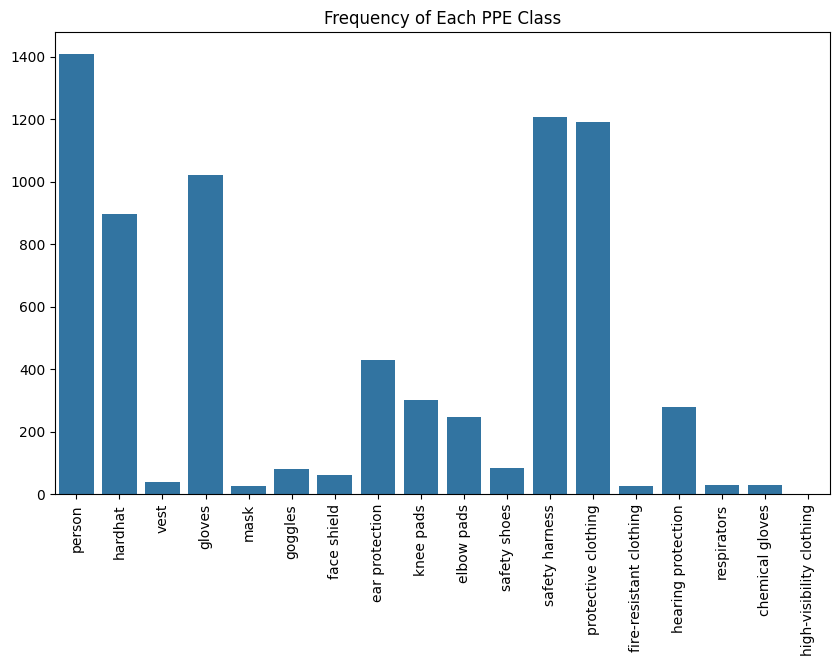

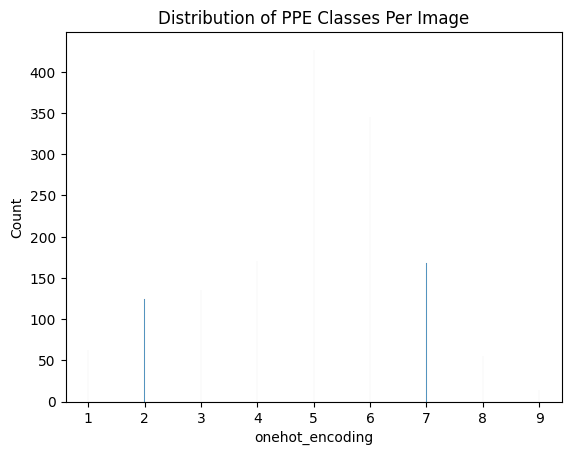

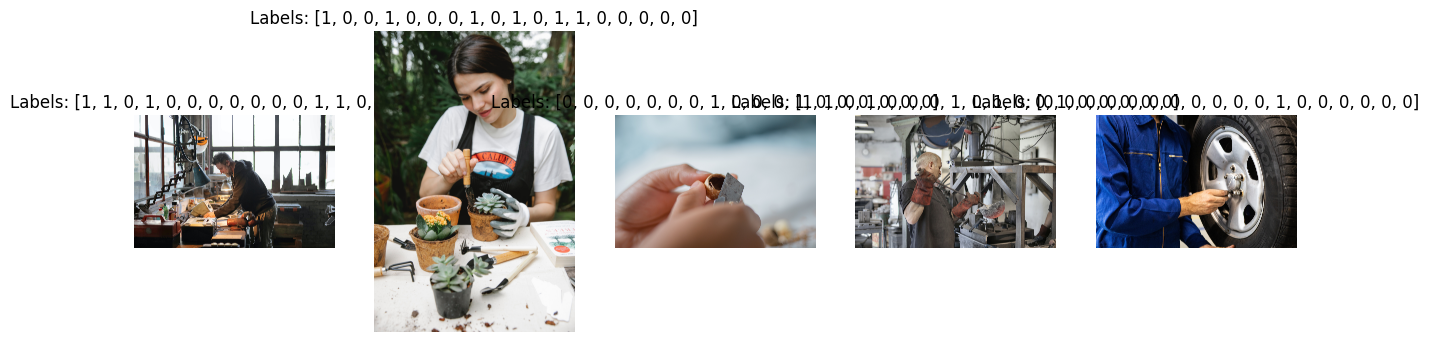

In [ ]:
# Apply preprocessing to images
df['preprocessed_image'] = df['image_path'].apply(preprocess_image)

# Define PPE classes
PPE_CLASSES = ['person', 'hardhat', 'vest', 'gloves', 'mask', 'goggles', 'face shield',
               'ear protection', 'knee pads', 'elbow pads', 'safety shoes',
               'safety harness', 'protective clothing', 'fire-resistant clothing',
               'hearing protection', 'respirators', 'chemical gloves',
               'high-visibility clothing']

# YOLO to one-hot encoding function
def yolo_to_onehot(label_path):
    onehot = [0] * len(PPE_CLASSES)
    try:
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id = int(line.split()[0])
                if class_id < len(PPE_CLASSES):
                    onehot[class_id] = 1
                else:
                    logging.error(f"Invalid class_id {class_id} in label file: {label_path}")
    except Exception as e:
        logging.error(f"Error reading label file {label_path}: {e}")
    return onehot

# Apply one-hot encoding to labels
df['onehot_encoding'] = df['label_path'].apply(yolo_to_onehot)

# Show preprocessed DataFrame
print(df.head())

# 4. Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Count frequency of each PPE class
class_frequencies = np.sum(np.array(df['onehot_encoding'].tolist()), axis=0)
plt.figure(figsize=(10, 6))
sns.barplot(x=PPE_CLASSES, y=class_frequencies)
plt.xticks(rotation=90)
plt.title('Frequency of Each PPE Class')
plt.show()

# Count number of PPE per image
class_counts = df['onehot_encoding'].apply(lambda x: sum(x))  # Count number of PPE per image
sns.histplot(class_counts, bins=len(class_counts))
plt.title('Distribution of PPE Classes Per Image')
plt.show()

# Visualize images with labels
import matplotlib.image as mpimg
def visualize_images_with_labels(df, n=5):
    plt.figure(figsize=(15, 10))
    for i in range(n):
        img = mpimg.imread(df['image_path'].iloc[i])
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Labels: {df['onehot_encoding'].iloc[i]}")
    plt.show()

visualize_images_with_labels(df)

# 5. Advanced Data Analytics - Neural Network for Classification
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X = np.array(df['preprocessed_image'].tolist())
y = np.array(df['onehot_encoding'].tolist())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X to fit the model
X_train = X_train.reshape(-1, 224, 224, 3)
X_val = X_val.reshape(-1, 224, 224, 3)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(len(PPE_CLASSES), activation='sigmoid')  # Multi-label classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20,
                    validation_data=(X_val, y_val))

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

                                      image_path  \
0  SH17_dataset/images/pexels-photo-3817785.jpeg   
1  SH17_dataset/images/pexels-photo-6231746.jpeg   
2  SH17_dataset/images/pexels-photo-7245746.jpeg   
3  SH17_dataset/images/pexels-photo-3845946.jpeg   
4  SH17_dataset/images/pexels-photo-8986177.jpeg   

                                     label_path  \
0  SH17_dataset/labels/pexels-photo-3817785.txt   
1  SH17_dataset/labels/pexels-photo-6231746.txt   
2  SH17_dataset/labels/pexels-photo-7245746.txt   
3  SH17_dataset/labels/pexels-photo-3845946.txt   
4  SH17_dataset/labels/pexels-photo-8986177.txt   

                                  preprocessed_image  \
0  [0.996078431372549, 0.9882352941176471, 0.9843...   
1  [0.058823529411764705, 0.06666666666666667, 0....   
2  [0.5568627450980392, 0.5098039215686274, 0.415...   
3  [0.9529411764705882, 0.9450980392156862, 0.941...   
4  [0.9176470588235294, 0.5019607843137255, 0.360...   

                                     onehot

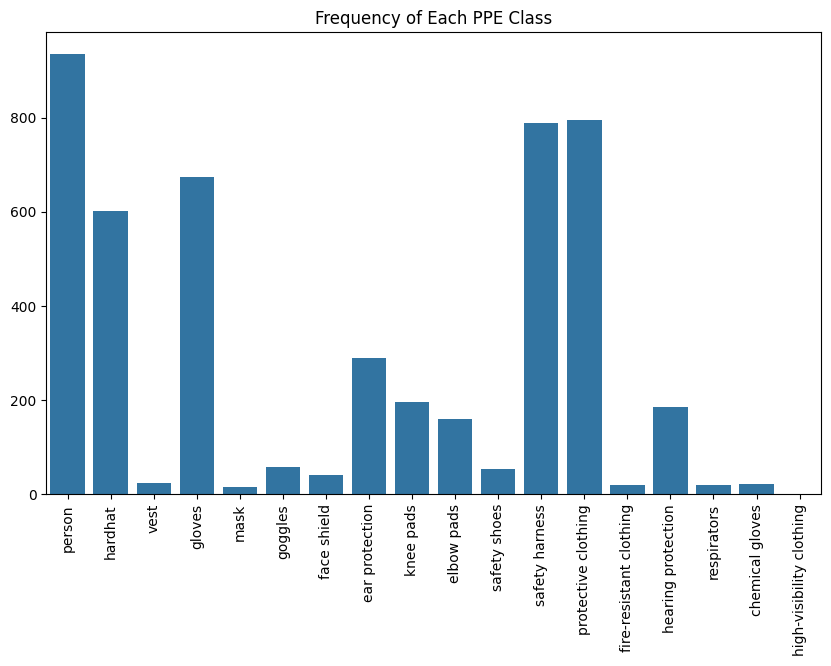

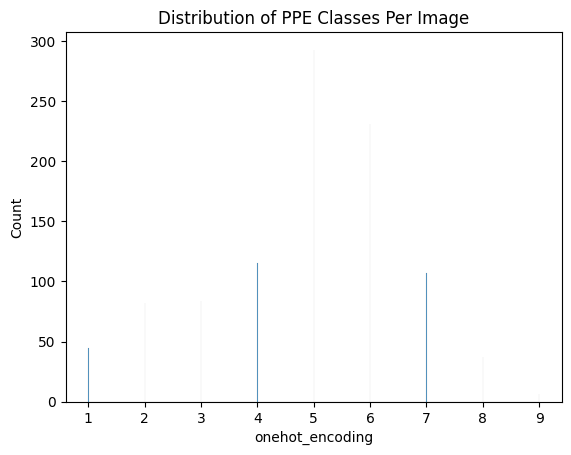

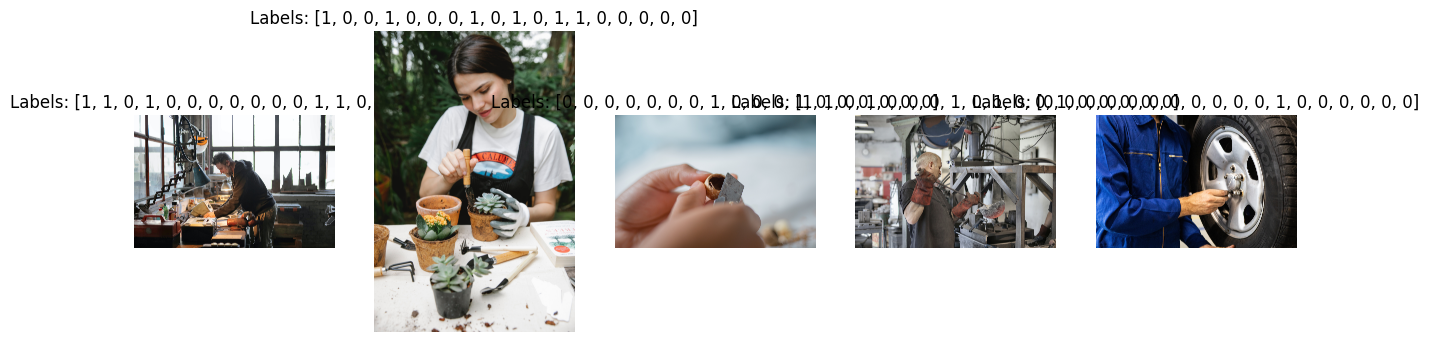

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.3300 - loss: 0.4918 - val_accuracy: 0.9300 - val_loss: 0.3000
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.6380 - loss: 0.3653 - val_accuracy: 0.9300 - val_loss: 0.3051
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.6805 - loss: 0.3605 - val_accuracy: 0.9300 - val_loss: 0.2927
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - accuracy: 0.7609 - loss: 0.3480 - val_accuracy: 0.9300 - val_loss: 0.3023
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.7735 - loss: 0.3458 - val_accuracy: 0.9300 - val_loss: 0.2967
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.8238 - loss: 0.3399 - val_accuracy: 0.9300 - val_loss: 0.3071
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 340ms/step - accuracy: 0.7925 - loss: 0.3261 - val_accuracy: 0.9300 - val_loss: 0.3081
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step - accuracy: 0.7941 - loss: 0.3313 - val_accuracy: 0.930

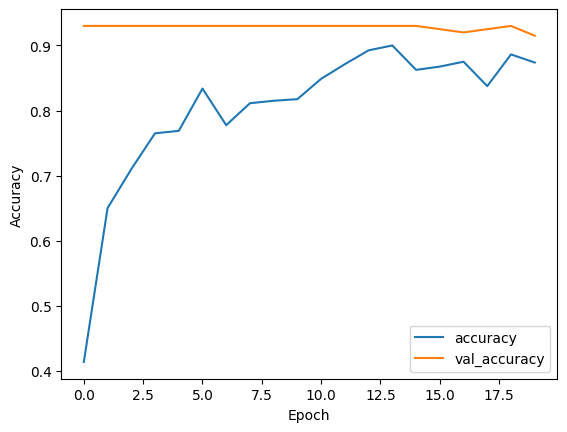

In [1]:
# 2. Data Cleaning and Preprocessing
import os
import pandas as pd
import cv2
import numpy as np
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define dataset paths
dataset_path = 'SH17_dataset'
image_dir = os.path.join(dataset_path, 'images')
label_dir = os.path.join(dataset_path, 'labels')

# Read image file paths and corresponding labels
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.jpeg', '.jpg'))]
label_paths = [os.path.join(label_dir, label) for label in os.listdir(label_dir) if label.endswith('.txt')]

# Pair images with their labels (use a smaller sample size to avoid crashes)
SAMPLE_SIZE = 1000  # Use a smaller subset of the dataset
image_paths_sample = image_paths[:SAMPLE_SIZE]

data = []
for image_path in image_paths_sample:
    label_path = image_path.replace('images', 'labels').replace('.jpeg', '.txt').replace('.jpg', '.txt')
    if os.path.exists(label_path):
        data.append({'image_path': image_path, 'label_path': label_path})
    else:
        logging.warning(f"Label file not found for image: {image_path}")

df = pd.DataFrame(data)

# Image preprocessing function
def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            logging.error(f"Failed to read image: {image_path}")
            return None  # Return None instead of zeros for better handling
        image = cv2.resize(image, (224, 224))
        image = image / 255.0  # Normalize pixel values
        return image.flatten().tolist()
    except Exception as e:
        logging.error(f"Error in preprocessing image {image_path}: {e}")
        return None

# Apply preprocessing to images
df['preprocessed_image'] = df['image_path'].apply(preprocess_image)

# Define PPE classes
PPE_CLASSES = ['person', 'hardhat', 'vest', 'gloves', 'mask', 'goggles', 'face shield',
               'ear protection', 'knee pads', 'elbow pads', 'safety shoes',
               'safety harness', 'protective clothing', 'fire-resistant clothing',
               'hearing protection', 'respirators', 'chemical gloves',
               'high-visibility clothing']

# YOLO to one-hot encoding function
def yolo_to_onehot(label_path):
    onehot = [0] * len(PPE_CLASSES)
    try:
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id = int(line.split()[0])
                if class_id < len(PPE_CLASSES):
                    onehot[class_id] = 1
                else:
                    logging.error(f"Invalid class_id {class_id} in label file: {label_path}")
    except Exception as e:
        logging.error(f"Error reading label file {label_path}: {e}")
    return onehot

# Apply one-hot encoding to labels
df['onehot_encoding'] = df['label_path'].apply(yolo_to_onehot)

# Show preprocessed DataFrame
print(df.head())

# 4. Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Count frequency of each PPE class
class_frequencies = np.sum(np.array(df['onehot_encoding'].tolist()), axis=0)
plt.figure(figsize=(10, 6))
sns.barplot(x=PPE_CLASSES, y=class_frequencies)
plt.xticks(rotation=90)
plt.title('Frequency of Each PPE Class')
plt.show()

# Count number of PPE per image
class_counts = df['onehot_encoding'].apply(lambda x: sum(x))  # Count number of PPE per image
sns.histplot(class_counts, bins=len(class_counts))
plt.title('Distribution of PPE Classes Per Image')
plt.show()

# Visualize images with labels
import matplotlib.image as mpimg
def visualize_images_with_labels(df, n=5):
    plt.figure(figsize=(15, 10))
    for i in range(n):
        img = mpimg.imread(df['image_path'].iloc[i])
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Labels: {df['onehot_encoding'].iloc[i]}")
    plt.show()

visualize_images_with_labels(df)

# 5. Advanced Data Analytics - Neural Network for Classification
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X = np.array(df['preprocessed_image'].tolist())
y = np.array(df['onehot_encoding'].tolist())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X to fit the model
X_train = X_train.reshape(-1, 224, 224, 3)
X_val = X_val.reshape(-1, 224, 224, 3)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(len(PPE_CLASSES), activation='sigmoid')  # Multi-label classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20,
                    validation_data=(X_val, y_val))

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [2]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,513,848 (127.85 MB)

 Trainable params: 11,171,282 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,342,566 (85.23 MB)

In [3]:
print(model)

<Sequential name=sequential, built=True>


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


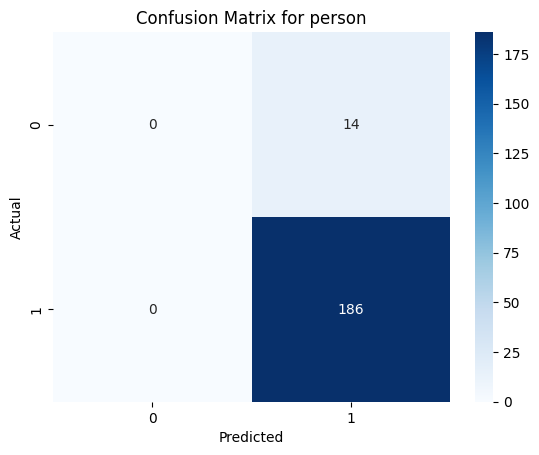

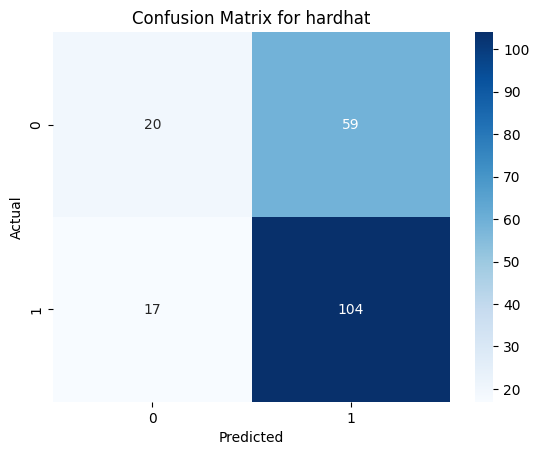

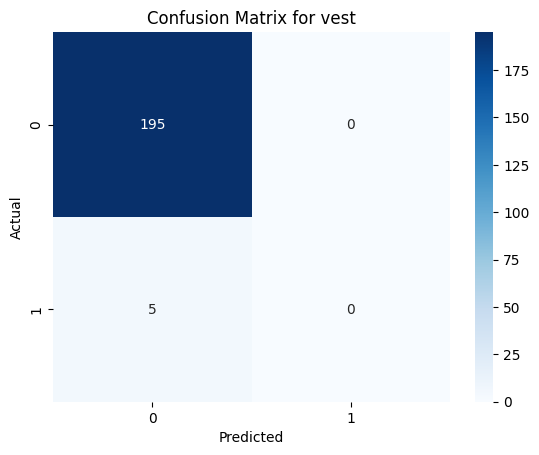

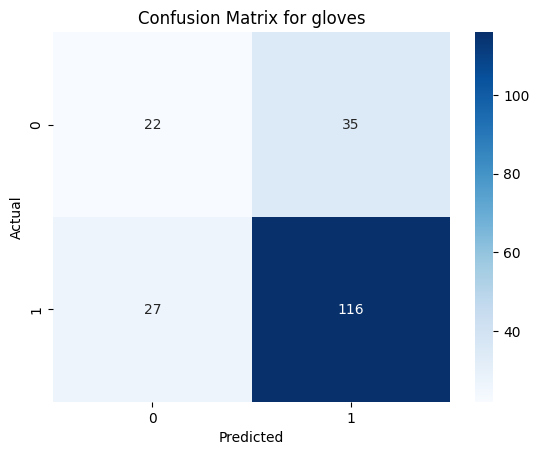

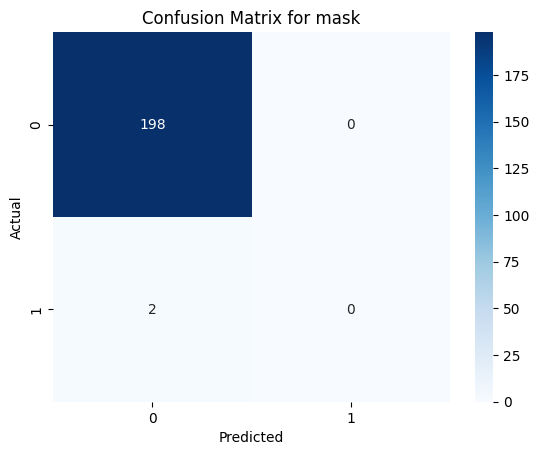

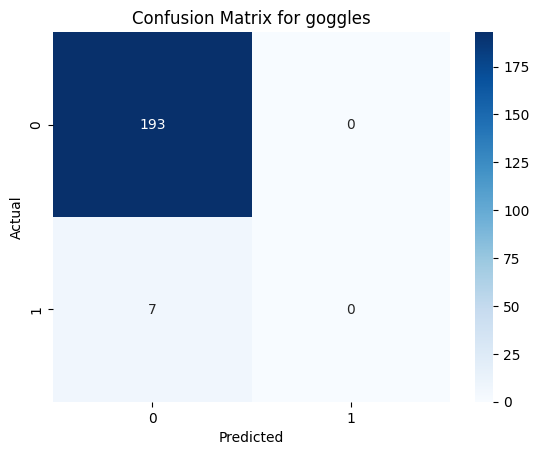

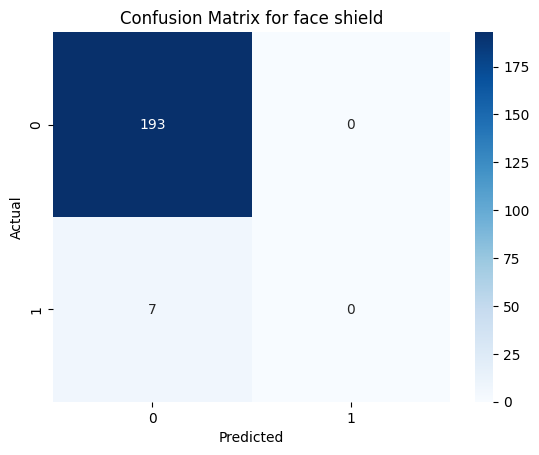

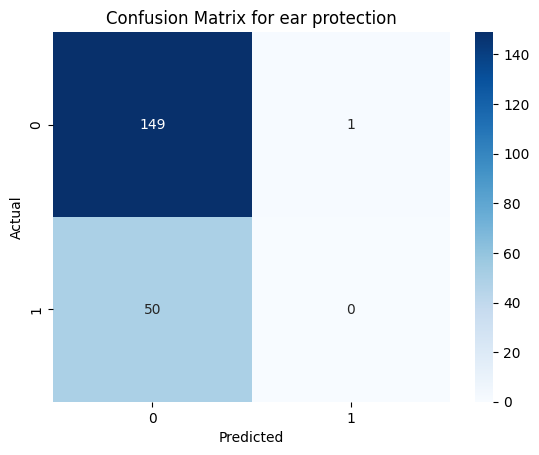

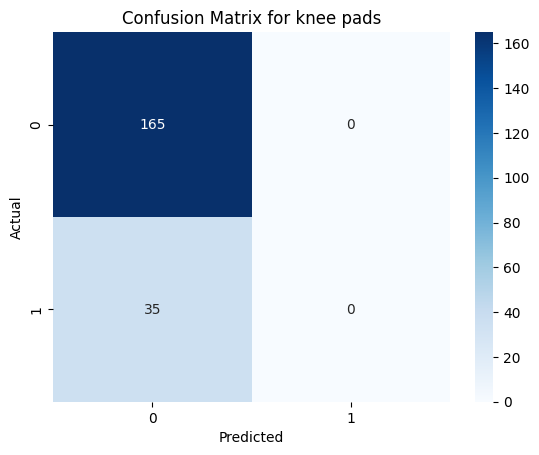

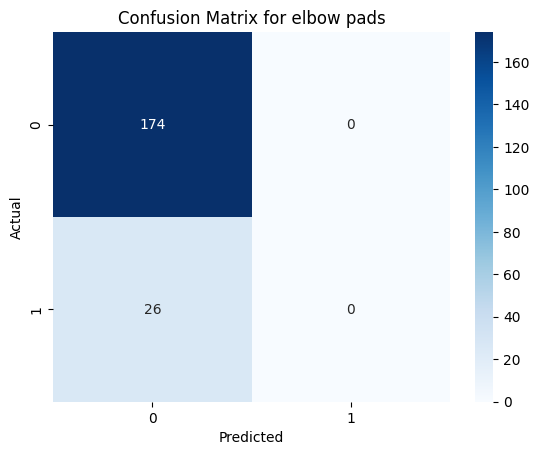

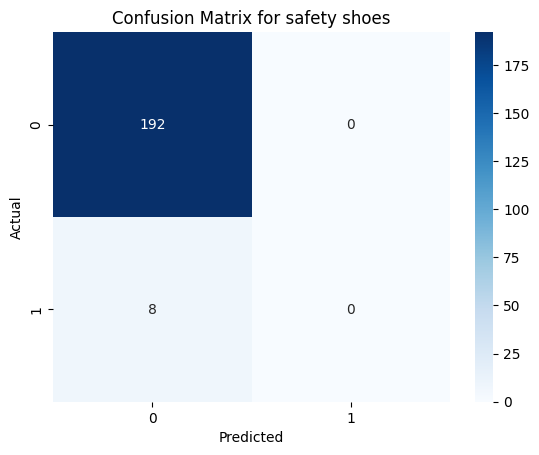

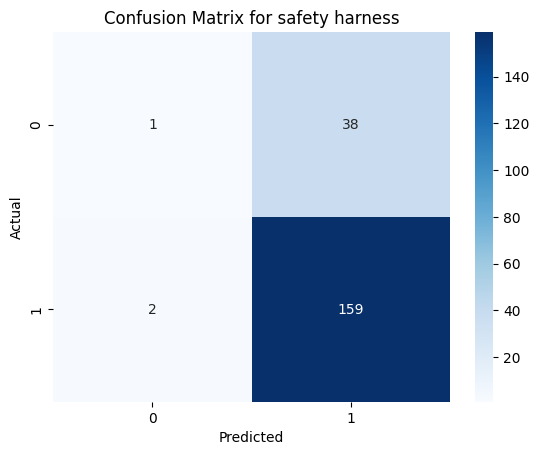

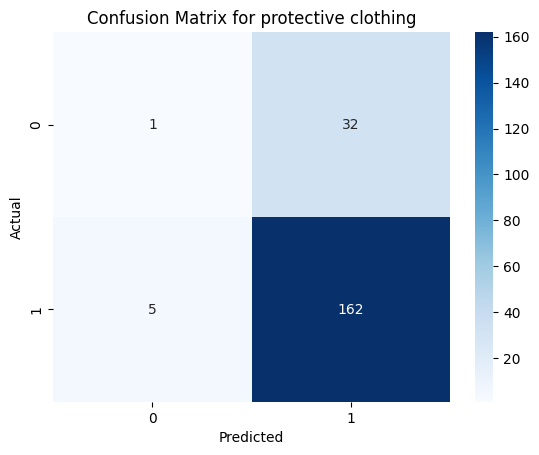

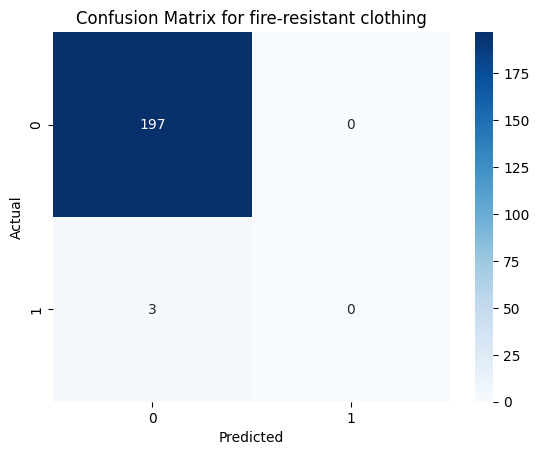

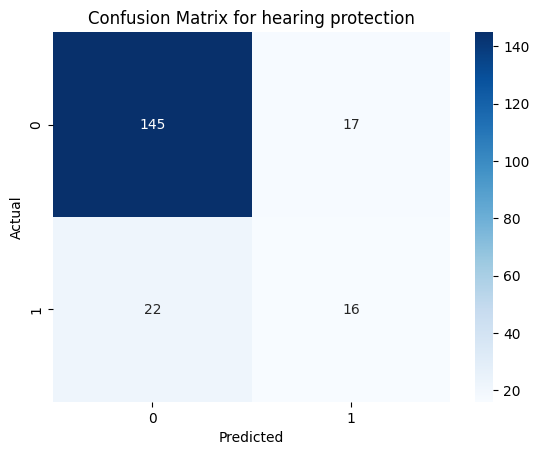

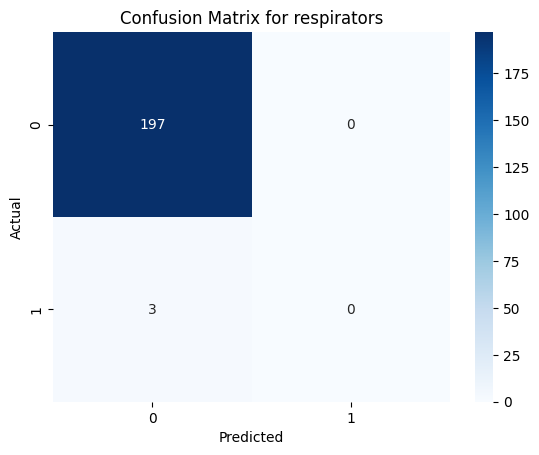

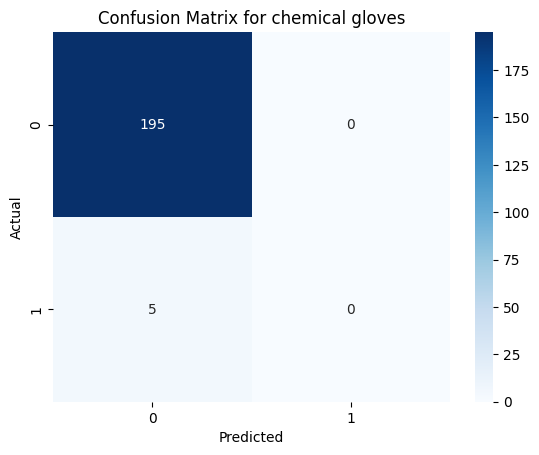

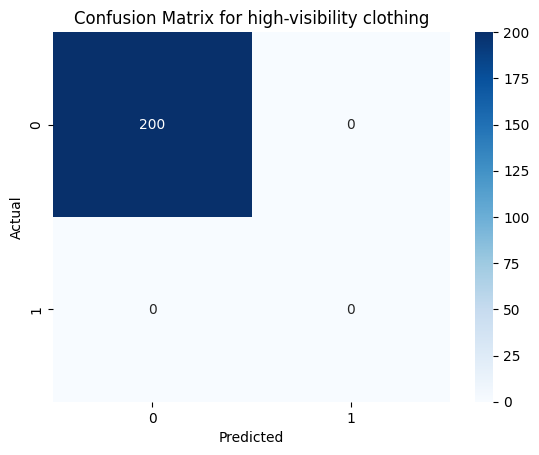

In [4]:
#Confusion Matrix
#For multi-label classification, we'll use a binary confusion matrix for each class.

from sklearn.metrics import multilabel_confusion_matrix

# Predict on validation set
y_pred = model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute confusion matrix
conf_matrix = multilabel_confusion_matrix(y_val, y_pred_binary)

for idx, cls in enumerate(PPE_CLASSES):
    cm = conf_matrix[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {cls}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

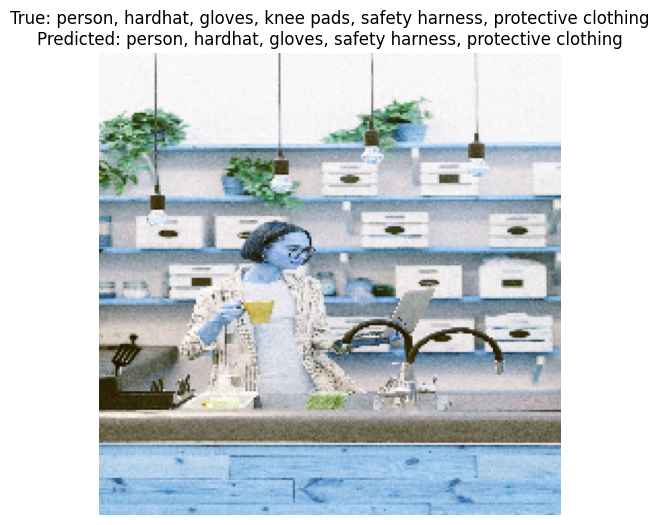

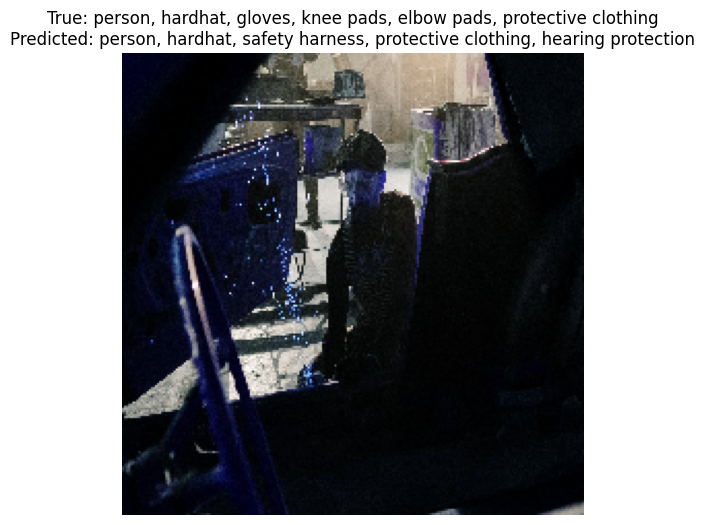

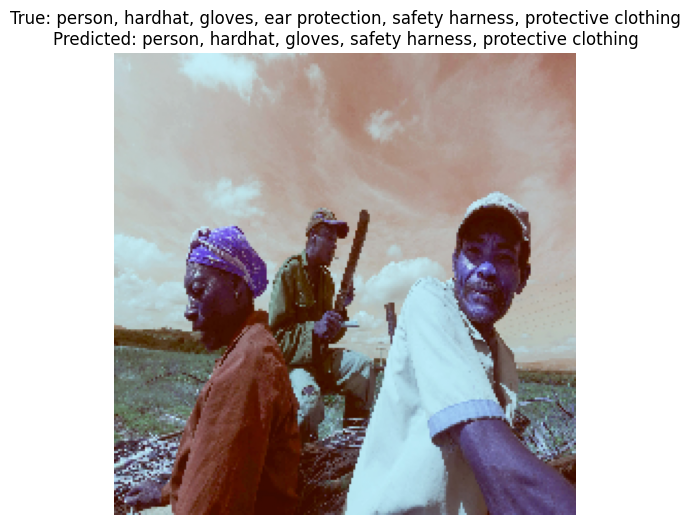

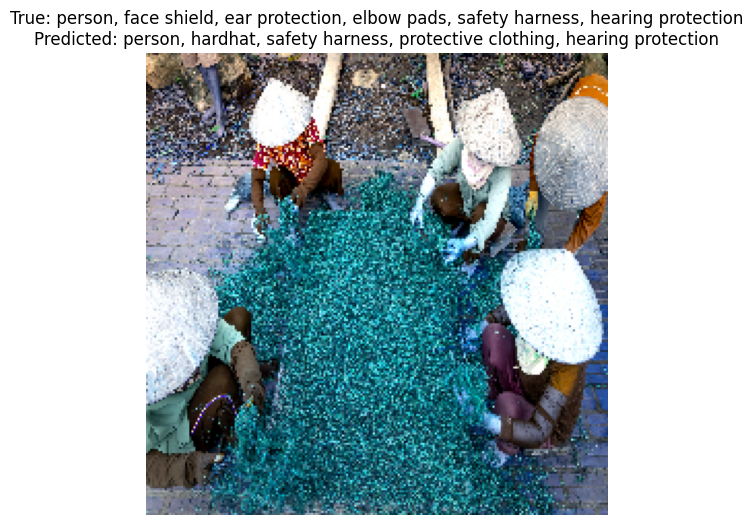

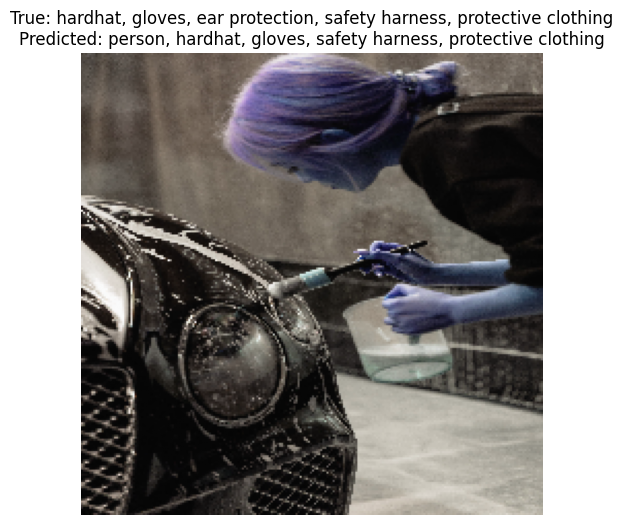

In [5]:
# Function to display image with predicted labels
def display_predictions(image, true_labels, pred_labels):
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.axis('off')
    title = "True: " + ", ".join([PPE_CLASSES[i] for i, val in enumerate(true_labels) if val==1])
    title += "\nPredicted: " + ", ".join([PPE_CLASSES[i] for i, val in enumerate(pred_labels) if val==1])
    plt.title(title)
    plt.show()

# Display a few sample predictions
for i in range(5):
    img = X_val[i]
    true = y_val[i]
    pred = y_pred_binary[i]
    display_predictions(img, true, pred)

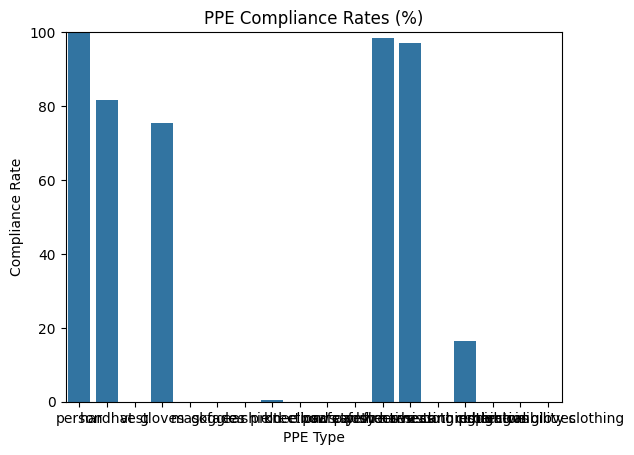

In [6]:
# Example: Bar chart showing PPE compliance rates
compliance_rates = y_pred_binary.mean(axis=0) * 100
sns.barplot(x=PPE_CLASSES, y=compliance_rates)
plt.title('PPE Compliance Rates (%)')
plt.ylabel('Compliance Rate')
plt.xlabel('PPE Type')
plt.ylim(0, 100)
plt.show()